<a href="https://colab.research.google.com/github/leahandofir/earthformer-inference-experiments/blob/main/google_colab_experiments/VGG16_loss_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pypng

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import png
import numpy as np
import matplotlib.pyplot as plt

def get_img(path):
  pixels = png.Reader(file=open(path, "rb")).asRGBA8()[2]
  np_arr = np.array([list(row) for row in pixels]).reshape(600,600,4)
  grayscale = 0.299 * np_arr[:,:,0] + 0.587 * np_arr[:,:,1] + 0.114 * np_arr[:,:,2]
  return grayscale

the code is taken from: https://github.com/pytorch/examples/blob/d91adc972cef0083231d22bcc75b7aaa30961863/fast_neural_style/neural_style/vgg.py

In [1]:
from collections import namedtuple

import torch
from torchvision import models


class Vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

In [83]:
img1 = get_img("/content/drive/MyDrive/data_from_IMS/ims_ir_png_samples/202301010000.png")
img2 = get_img("/content/drive/MyDrive/data_from_IMS/ims_ir_png_samples/202301011525.png")

In [20]:
vgg = Vgg16()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [53]:
import numpy as np

def img_to_tensor(img):
  img_rgb = np.stack([img/255, img/255, img/255], axis=0)
  return torch.Tensor(img_rgb)

In [54]:
img1_t = img_to_tensor(img1)
out1 = vgg(img1_t)

In [55]:
img2_t = img_to_tensor(img2)
out2 = vgg(img2_t)

In [56]:
from torch.nn import functional as F

In [80]:
F.mse_loss(out1.relu1_2, out2.relu1_2)

tensor(0.0545)

In [86]:
F.mse_loss(torch.Tensor(img1/255), torch.Tensor(img2/255))

tensor(0.0250)

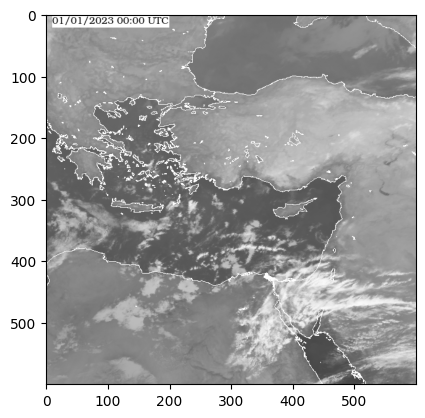

In [78]:
import matplotlib.pyplot as plt
i = np.stack([img1/255, img1/255, img1/255], axis=-1)
plt.imshow(i)

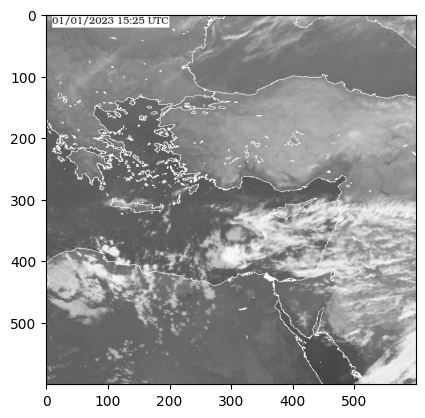

In [87]:
import matplotlib.pyplot as plt
i = np.stack([img2/255, img2/255, img2/255], axis=-1)
plt.imshow(i)